# TDS simulation

In this task, we'll simulate a thermo-desorption experiment where a sample is first loaded with hydrogen and then heated.

In [21]:
import festim as F

my_model = F.Simulation()

Let's create a mesh from a list of vertices with more refinement close to $x=0$.

In [22]:
import numpy as np

vertices = np.concatenate([
    np.linspace(0, 30e-9, num=200),
    np.linspace(30e-9, 3e-6, num=300),
    np.linspace(3e-6, 20e-6, num=200),
])


my_model.mesh = F.MeshFromVertices(vertices)

The material we want to simulate is tungsten. The only property we need is the diffusion coefficient.

In [23]:
tungsten = F.Material(
    id=1,
    D_0=4.1e-07,  # m2/s
    E_D=0.39,  # eV
)

my_model.materials = tungsten

## Hydrogen source

The source term is defined as:
\begin{equation}
    S_{ext} = \varphi \cdot f(x) \quad \forall \, t<400 \text{s}
\end{equation}

where $\varphi =2.5 \times 10^{19} \text{m}^{-2}\text{s}^{-1}$ and $f(x)$ is a Gaussian spatial distribution with a mean value of $4.5 \: \text{nm}$ and a width of $2.5 \: \text{nm}$.

Below, `t` is a built-in FESTIM variable that represent time in $\text{s}$.

In [24]:
import sympy as sp

ion_flux = sp.Piecewise((2.5e19, F.t <= 400), (0, True))

source_term = F.ImplantationFlux(
    flux=ion_flux,  # H/m2/s
    imp_depth=4.5e-9,  # m
    width=2.5e-9,  # m
    volume=1
)

my_model.sources = [source_term]

In FESTIM, each trap is defined by a `Trap` object.
Relevent arguments for each trap include:

`k_0` and `E_k` are the trapping rate pre-exponential factor in $\text{m}^{3} \text{s}^{-1}$ and activation energy in $\text{eV}$, respectively.

`p_0` and `E_p` are the detrapping rate pre-exponential factor in $\text{s}^{-1}$ and activation energy in $\text{eV}$, respectively.

`materials` is a list of the materials in which the trap is located.
Here, it's only `tungsten`.

In FESTIM, traps are intrinsic by default. However, traps can also be implemented as extrinsic, as shown in the example hereafter corresponding to 2 intrinsic and 1 extrinsic trap.

The time evolution of extrinsic traps density $n_i$ expressed in $\text{m}^{-3}$ is defined as:
\begin{equation}
    \frac{dn_i}{dt} = \varphi_0\:\left[\left(1-\frac{n_i}{n_{a_{max}}}\right)\:\eta_a \:f_a(x)+\left(1-\frac{n_i}{n_{b_{max}}}\right)\:\eta_b \:f_b(x)\right]
\end{equation}

In [25]:
w_atom_density = 6.3e28  # atom/m3

trap_1 = F.Trap(
        k_0=4.1e-7/(1.1e-10**2*6*w_atom_density),
        E_k=0.39,
        p_0=1e13,
        E_p=0.87,
        density=1.3e-3*w_atom_density,
        materials=tungsten
    )
trap_2 = F.Trap(
        k_0=4.1e-7/(1.1e-10**2*6*w_atom_density),
        E_k=0.39,
        p_0=1e13,
        E_p=1.0,
        density=4e-4*w_atom_density,
        materials=tungsten
    )

center = 4.5e-9
width = 2.5e-9
distribution = 1/(width*(2*sp.pi)**0.5) * sp.exp(-0.5*((F.x-center)/width)**2)
trap_3 = F.ExtrinsicTrap(
        k_0=4.1e-7/(1.1e-10**2*6*w_atom_density),
        E_k=0.39,
        p_0=1e13,
        E_p=1.5,
        phi_0=ion_flux,
        n_amax=1e-01*w_atom_density, f_a=distribution, eta_a=6e-4,
        n_bmax=1e-02*w_atom_density, f_b=sp.Piecewise((1e6, F.x < 1e-6), (0, True)), eta_b=2e-4,
        materials=tungsten
    )

my_model.traps = [trap_1, trap_2, trap_3]

Boundary conditions (BCs) can be of several types in FESTIM, the most simple of them being the `DirichletBC` where an analytical expression is given in the argument: `value`. The argument `surfaces` contains a list of all the surfaces on which the BC is applied. If no BC is applied on a surface, it will be considered as a non flux surface (ie $\frac{\partial c}{\partial\textbf{n}} = 0$).

In this case, the solute concentration is set to zero on surfaces 1 and 2 (left and right).

In [26]:
my_model.boundary_conditions = [
    F.DirichletBC(surfaces=[1, 2], value=0)
]

In this example, the temperature is constant from $t=0$ to $t=450 \text{s}$ (implantation phase), then increases from $t=450 \text{s}$ to $t=500 \text{s}$ in order to perform the thermo-desorption (TDS phase).

\begin{equation}
    T(t) =
    \begin{cases}
        300, & \text{if} \: t < 450 \\
        300 + 8(t - 450), & \text{else} \\
    \end{cases}
\end{equation}

$T$ is expressed in $\text{K}$.

In [27]:
my_model.T = F.Temperature(
    value=sp.Piecewise((300, F.t < 450), (300 + 8*(F.t-450), True))
)

The `Stepsize` object defines the simulation stepsize.

The argument `initial_value` is the initial stepsize is expressed in $\text{s}$.

An adaptive stepsize algorithm has been implemented in order to save computational cost.
`stepsize_change_ratio` defines by how much the stepsize is increased or decreased after each iteration (depending on the number of Newton iterations required to converged).
`dt_min` is the lower limit for the stepsize below which the computation will stop.

Note: the optional argument `t_stop` is the time when we want the stepsize to be below a value set in `stepsize_stop_max` in order to have temporal refinement at the end of the run. It is useful in our case since we want temporal refinement during the TDS phase.

In [28]:
my_model.dt = F.Stepsize(
    initial_value=0.5,
    stepsize_change_ratio=1.1,
    t_stop=430,
    stepsize_stop_max=0.5,
    dt_min=1e-05
)

In [29]:
my_model.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-09,
    maximum_iterations=50,
    final_time=500
)

We want to plot the evolution of the surface fluxes as a function of time.

To do so, we'll use 'derived quantities' objects.
There is a wide range of derived quantities available in FESTIM. Here, we'll use `TotalVolume` (volume integration) and `HydrogenFlux`.

In [30]:

list_of_derived_quantities = [
        F.TotalVolume("solute", volume=1),
        F.TotalVolume("retention", volume=1),
        F.TotalVolume("1", volume=1),
        F.TotalVolume("2", volume=1),
        F.TotalVolume("3", volume=1),
        F.HydrogenFlux(surface=1),
        F.HydrogenFlux(surface=2)
    ]

derived_quantities = F.DerivedQuantities(
    list_of_derived_quantities,
    filename="tds/derived_quantities.csv"
)


my_model.exports = F.Exports([derived_quantities])

In [31]:
my_model.initialise()
my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        5.0e+02 s    Ellapsed time so far: 34.5 s


In [32]:
t = derived_quantities.t
flux_left = derived_quantities.filter(fields="solute", surfaces=1).data
flux_right = derived_quantities.filter(fields="solute", surfaces=2).data

flux_total = -np.array(flux_left) - np.array(flux_right)

Text(0.5, 0, 'Time (s)')

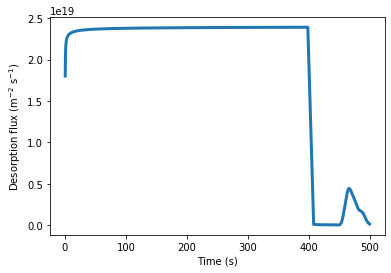

In [33]:
import matplotlib.pyplot as plt
plt.plot(t, flux_total, linewidth=3)

plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Time (s)")

Make use of numpy to compute the time derivative of the traps inventories!

In [34]:
trap_1 = derived_quantities.filter(fields="1").data
trap_2 = derived_quantities.filter(fields="2").data
trap_3 = derived_quantities.filter(fields="3").data

contribution_trap_1 = -np.diff(trap_1)/np.diff(t)
contribution_trap_2 = -np.diff(trap_2)/np.diff(t)
contribution_trap_3 = -np.diff(trap_3)/np.diff(t)

We can now plot the TDS spectrum with the 3 traps contributions

Text(0.5, 0, 'Time (s)')

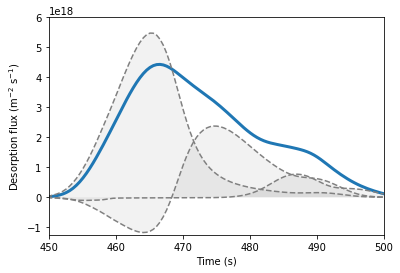

In [35]:
plt.plot(t, flux_total, linewidth=3)
plt.plot(t[1:], contribution_trap_1, linestyle="--", color="grey")
plt.fill_between(t[1:], 0, contribution_trap_1, facecolor='grey', alpha=0.1)
plt.plot(t[1:], contribution_trap_2, linestyle="--", color="grey")
plt.fill_between(t[1:], 0, contribution_trap_2, facecolor='grey', alpha=0.1)
plt.plot(t[1:], contribution_trap_3, linestyle="--", color="grey")
plt.fill_between(t[1:], 0, contribution_trap_3, facecolor='grey', alpha=0.1)

plt.xlim(450, 500)
plt.ylim(bottom=-1.25e18, top=0.6e19)
plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Time (s)")

plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Time (s)")